## Ratios Fundamentals por industria | API Finnhub
https://finnhub.io/

https://finnhub.io/docs/api/introduction

Este notebook implementa un sistema completo de análisis financiero comparativo diseñado específicamente para evaluar empresas del sector energético. Utilizando ExxonMobil (XOM) como empresa semilla, el sistema identifica automáticamente empresas competidoras y realiza un análisis multidimensional de métricas financieras clave.

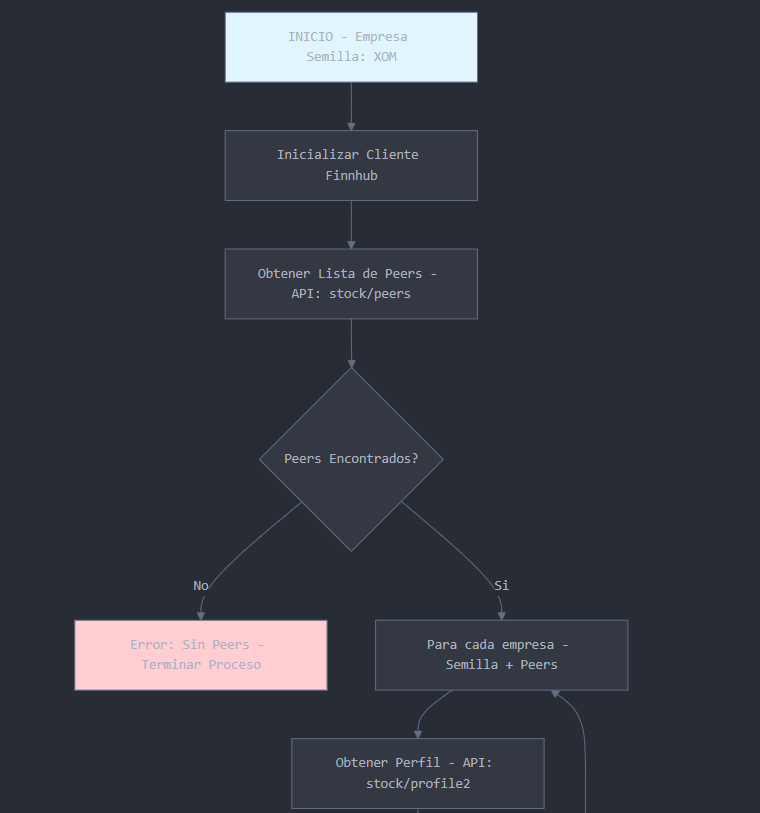



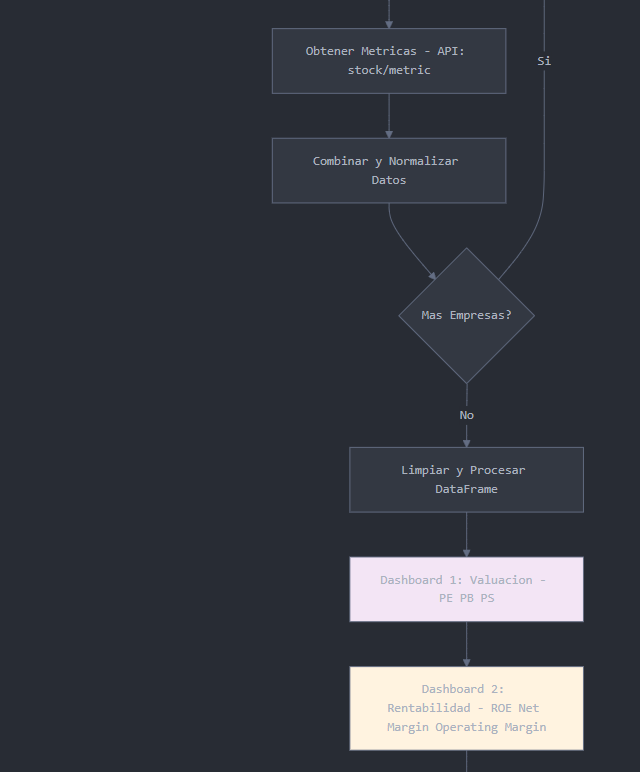
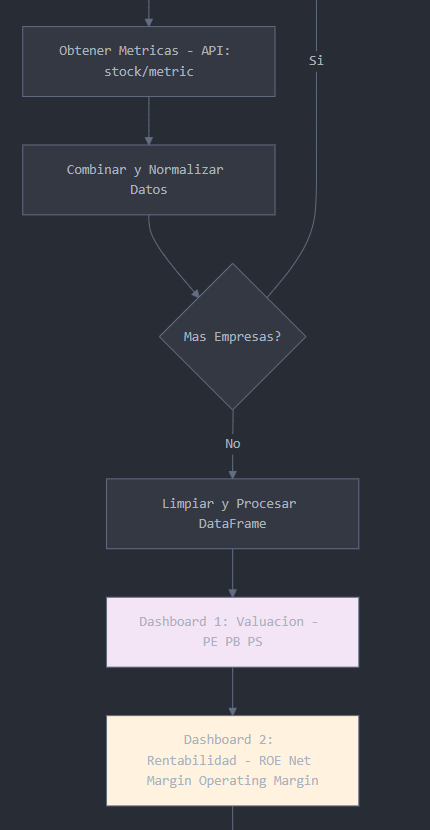

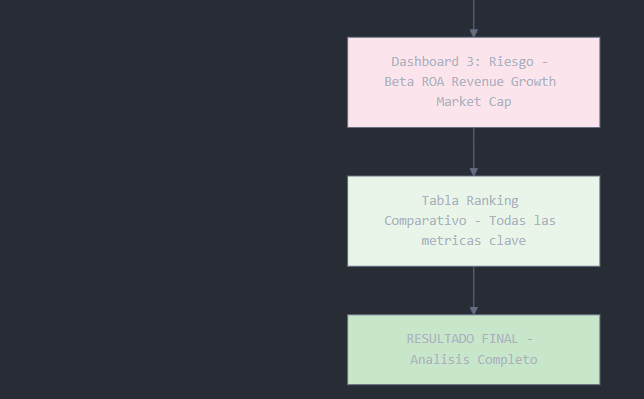
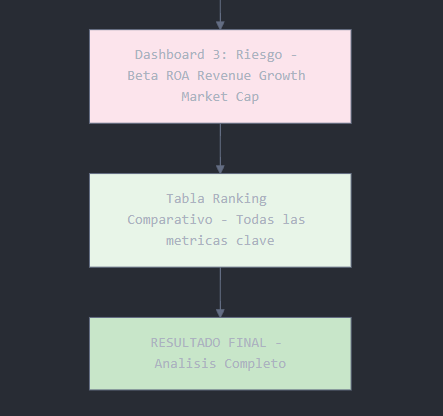
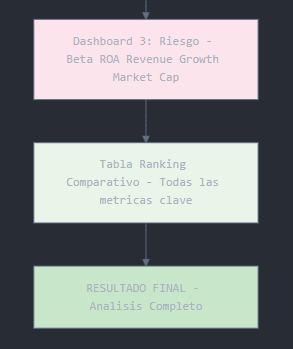

### Endpoint usado

In [61]:
import os
import requests
import pandas as pd

TOKEN = os.getenv("FINNHUB_TOKEN")

def get_all_metrics(symbol: str):
    url = "https://finnhub.io/api/v1/stock/metric" #exchange
    r = requests.get(url, params={"symbol": symbol, "metric": "all", "token": TOKEN}, timeout=10)
    r.raise_for_status()
    js = r.json()
    metrics = js.get("metric", {})
    return pd.DataFrame(metrics.items(), columns=["metric_name", "value"])

df['metric_name'].unique()


array(['10DayAverageTradingVolume', '13WeekPriceReturnDaily',
       '26WeekPriceReturnDaily', '3MonthADReturnStd',
       '3MonthAverageTradingVolume', '52WeekHigh', '52WeekHighDate',
       '52WeekLow', '52WeekLowDate', '52WeekPriceReturnDaily',
       '5DayPriceReturnDaily', 'assetTurnoverAnnual', 'assetTurnoverTTM',
       'beta', 'bookValuePerShareAnnual', 'bookValuePerShareQuarterly',
       'bookValueShareGrowth5Y', 'capexCagr5Y', 'cashFlowPerShareAnnual',
       'cashFlowPerShareQuarterly', 'cashFlowPerShareTTM',
       'cashPerSharePerShareAnnual', 'cashPerSharePerShareQuarterly',
       'currentDividendYieldTTM', 'currentEv/freeCashFlowAnnual',
       'currentEv/freeCashFlowTTM', 'currentRatioAnnual',
       'currentRatioQuarterly', 'dividendGrowthRate5Y',
       'dividendPerShareAnnual', 'dividendPerShareTTM',
       'dividendYieldIndicatedAnnual', 'ebitdPerShareAnnual',
       'ebitdPerShareTTM', 'ebitdaCagr5Y', 'ebitdaInterimCagr5Y',
       'enterpriseValue', 'epsAnnual', 

#### 1: Imports y configuración

In [ ]:
import os
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from dotenv import load_dotenv

# Cargar variables del archivo .env
load_dotenv()

# Ahora sí va a estar disponible
TOKEN = os.getenv("FINNHUB_TOKEN")


# Configurar paleta de colores
sns.set_palette("viridis")

#### 2: Cliente Finnhub

In [83]:
class FinnhubClient:
    def __init__(self, token: str = None):
        self.token = token or os.getenv("FINNHUB_TOKEN")
        self.base_url = 'https://finnhub.io/api/v1'
    
    def _make_request(self, endpoint: str, params: dict) -> dict:
        url = f"{self.base_url}/{endpoint}"
        params['token'] = self.token
        
        try:
            r = requests.get(url, params=params, timeout=10)
            r.raise_for_status()
            return r.json()
        except requests.RequestException as e:
            print(f"Error en {endpoint}: {e}")
            raise
    
    def get_peers(self, symbol: str) -> pd.DataFrame:
        response = self._make_request('stock/peers', {'symbol': symbol})
        
        if not isinstance(response, list):
            return pd.DataFrame(columns=['symbol'])
        
        return pd.DataFrame({'symbol': response})
    
    def get_profile(self, symbol: str) -> dict:
        return self._make_request('stock/profile2', {'symbol': symbol})
    
    def get_metrics(self, symbol: str, metric: str = 'all') -> dict:
        params = {'symbol': symbol, 'metric': metric}
        response = self._make_request('stock/metric', params)
        
        metrics = response.get('metric', {}) if isinstance(response, dict) else {}
        flat = {k: v if isinstance(v, (int, float, str, type(None))) else None 
                for k, v in metrics.items()}
        flat['symbol'] = symbol
        return flat

### 3: Función para obtener datos de la industria

In [84]:
def build_energy_batch(seed_symbol: str) -> pd.DataFrame:
    client = FinnhubClient()
    
    # Obtener peers
    peers_df = client.get_peers(seed_symbol) # Competidoras
    peers_list = peers_df['symbol'].tolist()
    all_symbols = [seed_symbol] + [p for p in peers_list if p != seed_symbol]
    
    metrics_rows = []
    for symbol in all_symbols:
        try:
            profile = client.get_profile(symbol) #Obtención del perfil
            metrics = client.get_metrics(symbol) # Obtención de métricas
            
            metrics.update({
                'industry': profile.get('finnhubIndustry', 'Energy'),
                'marketCap': profile.get('marketCapitalization'),
                'name': profile.get('name', symbol),
                'is_seed': symbol == seed_symbol
            })
            metrics_rows.append(metrics)
                
        except Exception as e:
            print(f"Error procesando {symbol}: {e}")
            metrics_rows.append({
                'symbol': symbol, 
                'industry': 'Energy', 
                'name': symbol,
                'is_seed': symbol == seed_symbol
            })
    
    df_metrics = pd.DataFrame(metrics_rows)
    
    # Convertir columnas numéricas
    numeric_cols = ['peTTM', 'pb', 'psTTM', 'roeTTM', 'netProfitMarginTTM', 
                   'operatingMarginTTM', 'marketCap', 'beta', 'eps', 
                   'bookValuePerShareTTM', 'roa5Y', 'revenueGrowth5Y'] #si quieren evaluar una industria en crecimiento, no usar TTM, usar forward.
    
    for col in numeric_cols:
        if col in df_metrics.columns:
            df_metrics[col] = pd.to_numeric(df_metrics[col], errors='coerce')
    
    return df_metrics

### 4: Funciones auxiliares de limpieza y transformación

In [85]:

def safe_dropna(df: pd.DataFrame, column: str) -> pd.DataFrame:
    if column in df.columns:
        return df.dropna(subset=[column])
    else:
        return pd.DataFrame()

def safe_get_column(df: pd.DataFrame, column: str) -> pd.Series:
    if column in df.columns:
        return df[column]
    else:
        return pd.Series(dtype=float) #En vez de largar un error, me va a devolver una serie vacía. #Así no se rompe el código.



### 5 Dashboards

In [86]:
# Dashboard de Valuación
def create_valuation_dashboard(df):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle('Dashboard de Valuación - Sector Energético', fontsize=18, fontweight='bold', y=1.02)
    
    colors = ['#e74c3c' if x else '#3498db' for x in df['is_seed']]
    
    # P/E Ratio
    valid_pe = safe_dropna(df, 'peTTM')
    if not valid_pe.empty:
        axes[0].bar(valid_pe['symbol'], valid_pe['peTTM'], color=[colors[i] for i in valid_pe.index])
        axes[0].set_title('Price/Earnings Ratio (TTM)', fontsize=14, fontweight='bold')
        axes[0].tick_params(axis='x', rotation=45)
        axes[0].grid(True, alpha=0.3)
        
        pe_mean = valid_pe['peTTM'].mean()
        axes[0].axhline(pe_mean, color='orange', linestyle='--', alpha=0.7, label=f'Promedio: {pe_mean:.1f}')
        axes[0].legend()
    else:
        axes[0].text(0.5, 0.5, 'Datos P/E no disponibles', ha='center', va='center', transform=axes[0].transAxes)
        axes[0].set_title('Price/Earnings Ratio (TTM)', fontsize=14, fontweight='bold')
    
    # P/B Ratio
    valid_pb = safe_dropna(df, 'pb')
    if not valid_pb.empty:
        axes[1].bar(valid_pb['symbol'], valid_pb['pb'], color=[colors[i] for i in valid_pb.index])
        axes[1].set_title('Price/Book Ratio', fontsize=14, fontweight='bold')
        axes[1].tick_params(axis='x', rotation=45)
        axes[1].grid(True, alpha=0.3)
        
        pb_mean = valid_pb['pb'].mean()
        axes[1].axhline(pb_mean, color='orange', linestyle='--', alpha=0.7, label=f'Promedio: {pb_mean:.1f}')
        axes[1].legend()
    else:
        axes[1].text(0.5, 0.5, 'Datos P/B no disponibles', ha='center', va='center', transform=axes[1].transAxes)
        axes[1].set_title('Price/Book Ratio', fontsize=14, fontweight='bold')
    
    # P/S Ratio
    valid_ps = safe_dropna(df, 'psTTM')
    if not valid_ps.empty:
        axes[2].bar(valid_ps['symbol'], valid_ps['psTTM'], color=[colors[i] for i in valid_ps.index])
        axes[2].set_title('Price/Sales Ratio (TTM)', fontsize=14, fontweight='bold')
        axes[2].tick_params(axis='x', rotation=45)
        axes[2].grid(True, alpha=0.3)
        
        ps_mean = valid_ps['psTTM'].mean()
        axes[2].axhline(ps_mean, color='orange', linestyle='--', alpha=0.7, label=f'Promedio: {ps_mean:.1f}')
        axes[2].legend()
    else:
        axes[2].text(0.5, 0.5, 'Datos P/S no disponibles', ha='center', va='center', transform=axes[2].transAxes)
        axes[2].set_title('Price/Sales Ratio (TTM)', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    return fig

In [87]:
#  Dashboard de Rentabilidad
def create_profitability_dashboard(df):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle('Dashboard de Rentabilidad - Sector Energético', fontsize=18, fontweight='bold', y=1.02)
    
    colors = ['#e74c3c' if x else '#3498db' for x in df['is_seed']]
    
    # ROE
    valid_roe = safe_dropna(df, 'roeTTM')
    if not valid_roe.empty:
        axes[0].bar(valid_roe['symbol'], valid_roe['roeTTM'], color=[colors[i] for i in valid_roe.index])
        axes[0].set_title('Return on Equity (TTM)', fontsize=14, fontweight='bold')
        axes[0].tick_params(axis='x', rotation=45)
        axes[0].grid(True, alpha=0.3)
        axes[0].set_ylabel('ROE')
        
        roe_mean = valid_roe['roeTTM'].mean()
        axes[0].axhline(roe_mean, color='orange', linestyle='--', alpha=0.7, label=f'Promedio: {roe_mean:.3f}')
        axes[0].legend()
    else:
        axes[0].text(0.5, 0.5, 'Datos ROE no disponibles', ha='center', va='center', transform=axes[0].transAxes)
        axes[0].set_title('Return on Equity (TTM)', fontsize=14, fontweight='bold')
    
    # Net Profit Margin
    valid_npm = safe_dropna(df, 'netProfitMarginTTM')
    if not valid_npm.empty:
        axes[1].bar(valid_npm['symbol'], valid_npm['netProfitMarginTTM'], color=[colors[i] for i in valid_npm.index])
        axes[1].set_title('Net Profit Margin (TTM)', fontsize=14, fontweight='bold')
        axes[1].tick_params(axis='x', rotation=45)
        axes[1].grid(True, alpha=0.3)
        axes[1].set_ylabel('Margin')
        
        npm_mean = valid_npm['netProfitMarginTTM'].mean()
        axes[1].axhline(npm_mean, color='orange', linestyle='--', alpha=0.7, label=f'Promedio: {npm_mean:.3f}')
        axes[1].legend()
    else:
        axes[1].text(0.5, 0.5, 'Datos Net Profit Margin no disponibles', ha='center', va='center', transform=axes[1].transAxes)
        axes[1].set_title('Net Profit Margin (TTM)', fontsize=14, fontweight='bold')
    
    # Operating Margin
    valid_om = safe_dropna(df, 'operatingMarginTTM')
    if not valid_om.empty:
        axes[2].bar(valid_om['symbol'], valid_om['operatingMarginTTM'], color=[colors[i] for i in valid_om.index])
        axes[2].set_title('Operating Margin (TTM)', fontsize=14, fontweight='bold')
        axes[2].tick_params(axis='x', rotation=45)
        axes[2].grid(True, alpha=0.3)
        axes[2].set_ylabel('Margin')
        
        om_mean = valid_om['operatingMarginTTM'].mean()
        axes[2].axhline(om_mean, color='orange', linestyle='--', alpha=0.7, label=f'Promedio: {om_mean:.3f}')
        axes[2].legend()
    else:
        axes[2].text(0.5, 0.5, 'Datos Operating Margin no disponibles', ha='center', va='center', transform=axes[2].transAxes)
        axes[2].set_title('Operating Margin (TTM)', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    return fig

In [88]:
#  Dashboard de Riesgo y Métricas Adicionales
def create_risk_liquidity_dashboard(df):
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle('Dashboard de Riesgo y Métricas Adicionales - Sector Energético', fontsize=18, fontweight='bold', y=0.95)
    
    colors = ['#e74c3c' if x else '#3498db' for x in df['is_seed']]
    
    # Beta
    valid_beta = safe_dropna(df, 'beta')
    if not valid_beta.empty:
        axes[0,0].bar(valid_beta['symbol'], valid_beta['beta'], color=[colors[i] for i in valid_beta.index])
        axes[0,0].set_title('Beta (Riesgo Sistemático)', fontsize=14, fontweight='bold')
        axes[0,0].tick_params(axis='x', rotation=45)
        axes[0,0].grid(True, alpha=0.3)
        axes[0,0].axhline(1.0, color='orange', linestyle='--', alpha=0.7, label='Beta = 1.0')
        
        beta_mean = valid_beta['beta'].mean()
        axes[0,0].axhline(beta_mean, color='purple', linestyle='--', alpha=0.7, label=f'Promedio: {beta_mean:.2f}')
        axes[0,0].legend()
    else:
        axes[0,0].text(0.5, 0.5, 'Datos Beta no disponibles', ha='center', va='center', transform=axes[0,0].transAxes)
        axes[0,0].set_title('Beta (Riesgo Sistemático)', fontsize=14, fontweight='bold')
    
    # ROA (Return on Assets)
    valid_roa = safe_dropna(df, 'roa5Y')
    if not valid_roa.empty:
        axes[0,1].bar(valid_roa['symbol'], valid_roa['roa5Y'], color=[colors[i] for i in valid_roa.index])
        axes[0,1].set_title('Return on Assets (5Y)', fontsize=14, fontweight='bold')
        axes[0,1].tick_params(axis='x', rotation=45)
        axes[0,1].grid(True, alpha=0.3)
        axes[0,1].set_ylabel('ROA')
        
        roa_mean = valid_roa['roa5Y'].mean()
        axes[0,1].axhline(roa_mean, color='purple', linestyle='--', alpha=0.7, label=f'Promedio: {roa_mean:.3f}')
        axes[0,1].legend()
    else:
        axes[0,1].text(0.5, 0.5, 'Datos ROA no disponibles', ha='center', va='center', transform=axes[0,1].transAxes)
        axes[0,1].set_title('Return on Assets (5Y)', fontsize=14, fontweight='bold')
    
    # Revenue Growth
    valid_rg = safe_dropna(df, 'revenueGrowth5Y')
    if not valid_rg.empty:
        axes[1,0].bar(valid_rg['symbol'], valid_rg['revenueGrowth5Y'], color=[colors[i] for i in valid_rg.index])
        axes[1,0].set_title('Revenue Growth (5Y)', fontsize=14, fontweight='bold')
        axes[1,0].tick_params(axis='x', rotation=45)
        axes[1,0].grid(True, alpha=0.3)
        axes[1,0].set_ylabel('Growth Rate')
        
        rg_mean = valid_rg['revenueGrowth5Y'].mean()
        axes[1,0].axhline(rg_mean, color='purple', linestyle='--', alpha=0.7, label=f'Promedio: {rg_mean:.3f}')
        axes[1,0].legend()
    else:
        axes[1,0].text(0.5, 0.5, 'Datos Revenue Growth no disponibles', ha='center', va='center', transform=axes[1,0].transAxes)
        axes[1,0].set_title('Revenue Growth (5Y)', fontsize=14, fontweight='bold')
    
    # Market Cap
    valid_mc = safe_dropna(df, 'marketCap')
    if not valid_mc.empty:
        market_caps = valid_mc['marketCap'] / 1000  # En miles de millones
        axes[1,1].bar(valid_mc['symbol'], market_caps, color=[colors[i] for i in valid_mc.index])
        axes[1,1].set_title('Market Capitalization', fontsize=14, fontweight='bold')
        axes[1,1].tick_params(axis='x', rotation=45)
        axes[1,1].grid(True, alpha=0.3)
        axes[1,1].set_ylabel('Market Cap (Billions)')
        
        mc_mean = market_caps.mean()
        axes[1,1].axhline(mc_mean, color='purple', linestyle='--', alpha=0.7, label=f'Promedio: ${mc_mean:.1f}B')
        axes[1,1].legend()
    else:
        axes[1,1].text(0.5, 0.5, 'Datos Market Cap no disponibles', ha='center', va='center', transform=axes[1,1].transAxes)
        axes[1,1].set_title('Market Capitalization', fontsize=14, fontweight='bold')
    
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    return fig

### 8 Tabla de ranking

In [89]:
def create_ranking_table(df):
    print("\n" + "="*80)
    print("RANKING COMPARATIVO - SECTOR ENERGÉTICO")
    print("Empresa Semilla: XOM")
    print("="*80)
    
    ranking_metrics = {
        'P/E TTM': 'peTTM',
        'P/B': 'pb', 
        'P/S TTM': 'psTTM',
        'ROE TTM (%)': 'roeTTM',
        'Net Margin TTM (%)': 'netProfitMarginTTM'
    }
    
    print(f"{'Symbol':<8} {'Company':<25} ", end="")
    for metric_name in ranking_metrics.keys():
        print(f"{metric_name:<15}", end="")
    print()
    print("-" * 110)
    
    for _, row in df.iterrows():
        symbol = row['symbol']
        name = row.get('name', symbol)[:23]
        is_seed_marker = " (*)" if row['is_seed'] else ""
        
        print(f"{symbol:<8} {name:<25}{is_seed_marker}", end="")
        
        for metric_name, metric_col in ranking_metrics.items():
            if metric_col in df.columns:
                value = row.get(metric_col)
                if pd.isna(value):
                    print(f"{'N/A':<15}", end="")
                else:
                    if 'ROE' in metric_name or 'Margin' in metric_name:
                        print(f"{value:.3f}{'':<10}", end="")
                    else:
                        print(f"{value:.2f}{'':<10}", end="")
            else:
                print(f"{'N/A':<15}", end="")
        print()
    
    print("\n(*) Empresa semilla")


### 9 Ejecución principal del programa:

In [90]:
# Función principal de análisis
def analyze_energy_sector():
    print("ANALIZANDO SECTOR ENERGÉTICO - XOM")
    print("="*50)
    
    # Obtener datos
    df_metrics = build_energy_batch('XOM')
    
    # Crear dashboards
    print(f"\nEmpresas analizadas: {len(df_metrics)}")
    
    # Dashboard 1: Valuación
    fig1 = create_valuation_dashboard(df_metrics)
    plt.show()
    
    # Dashboard 2: Rentabilidad
    fig2 = create_profitability_dashboard(df_metrics)
    plt.show()
    
    # Dashboard 3: Riesgo y Liquidez
    fig3 = create_risk_liquidity_dashboard(df_metrics)
    plt.show()
    
    # Tabla de ranking
    create_ranking_table(df_metrics)
    
    return df_metrics

ANALIZANDO SECTOR ENERGÉTICO - XOM

Empresas analizadas: 4


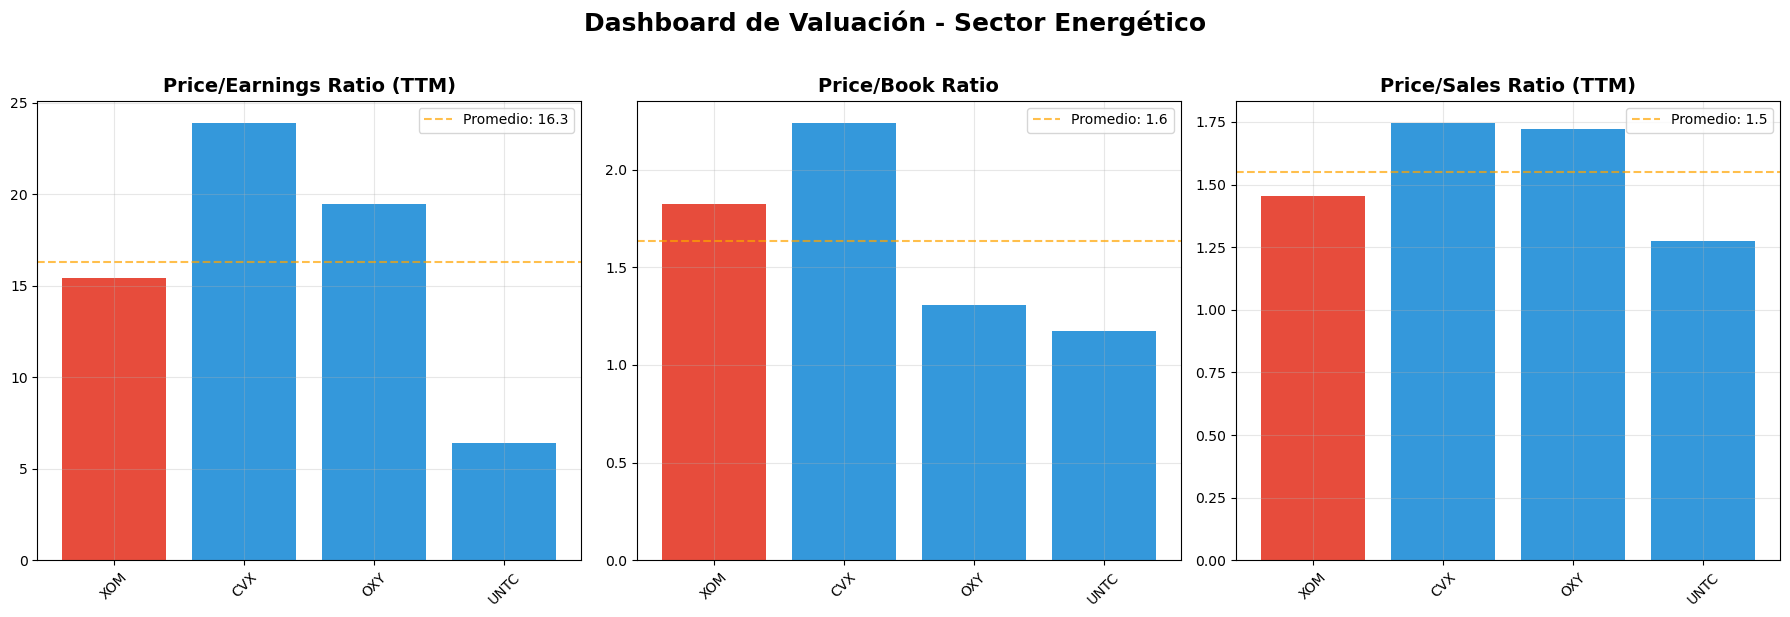

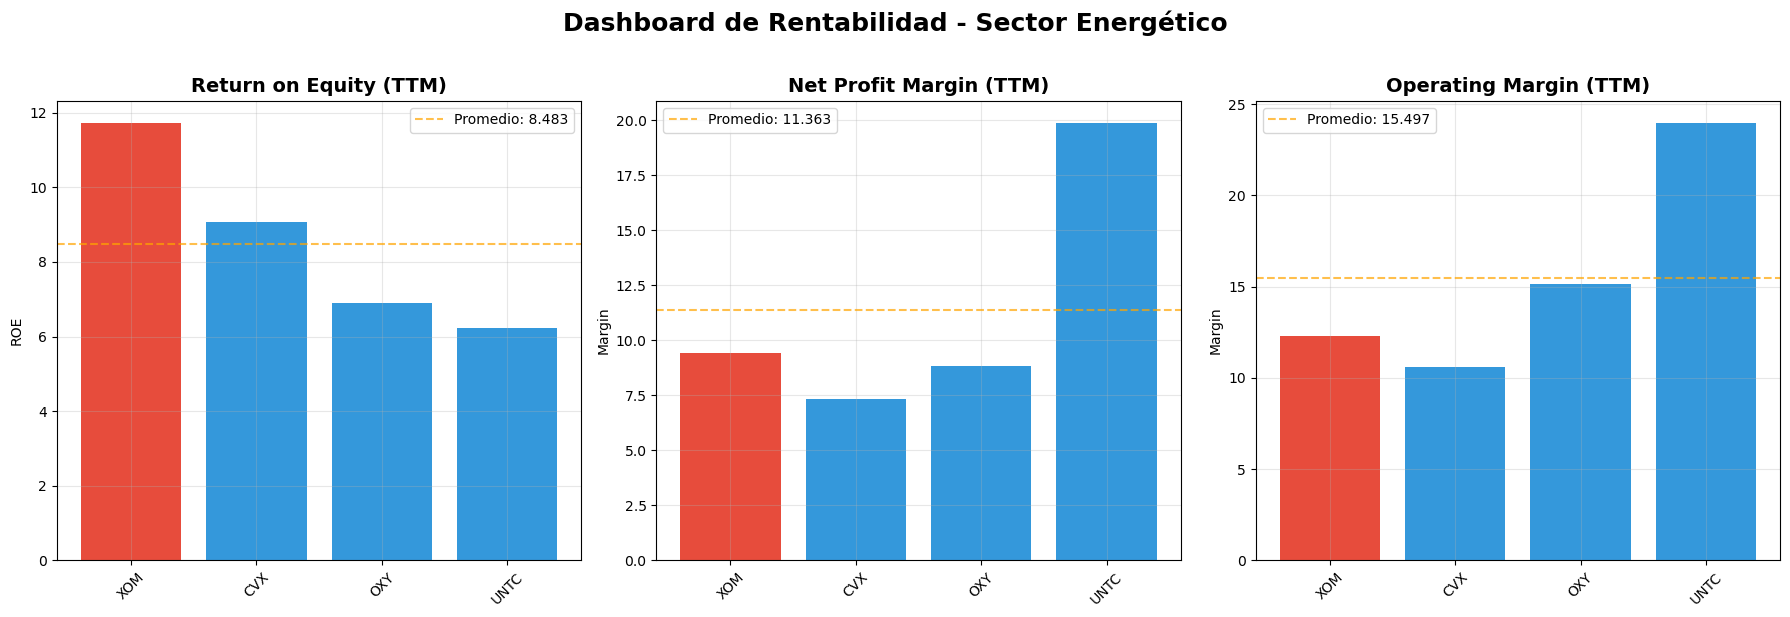

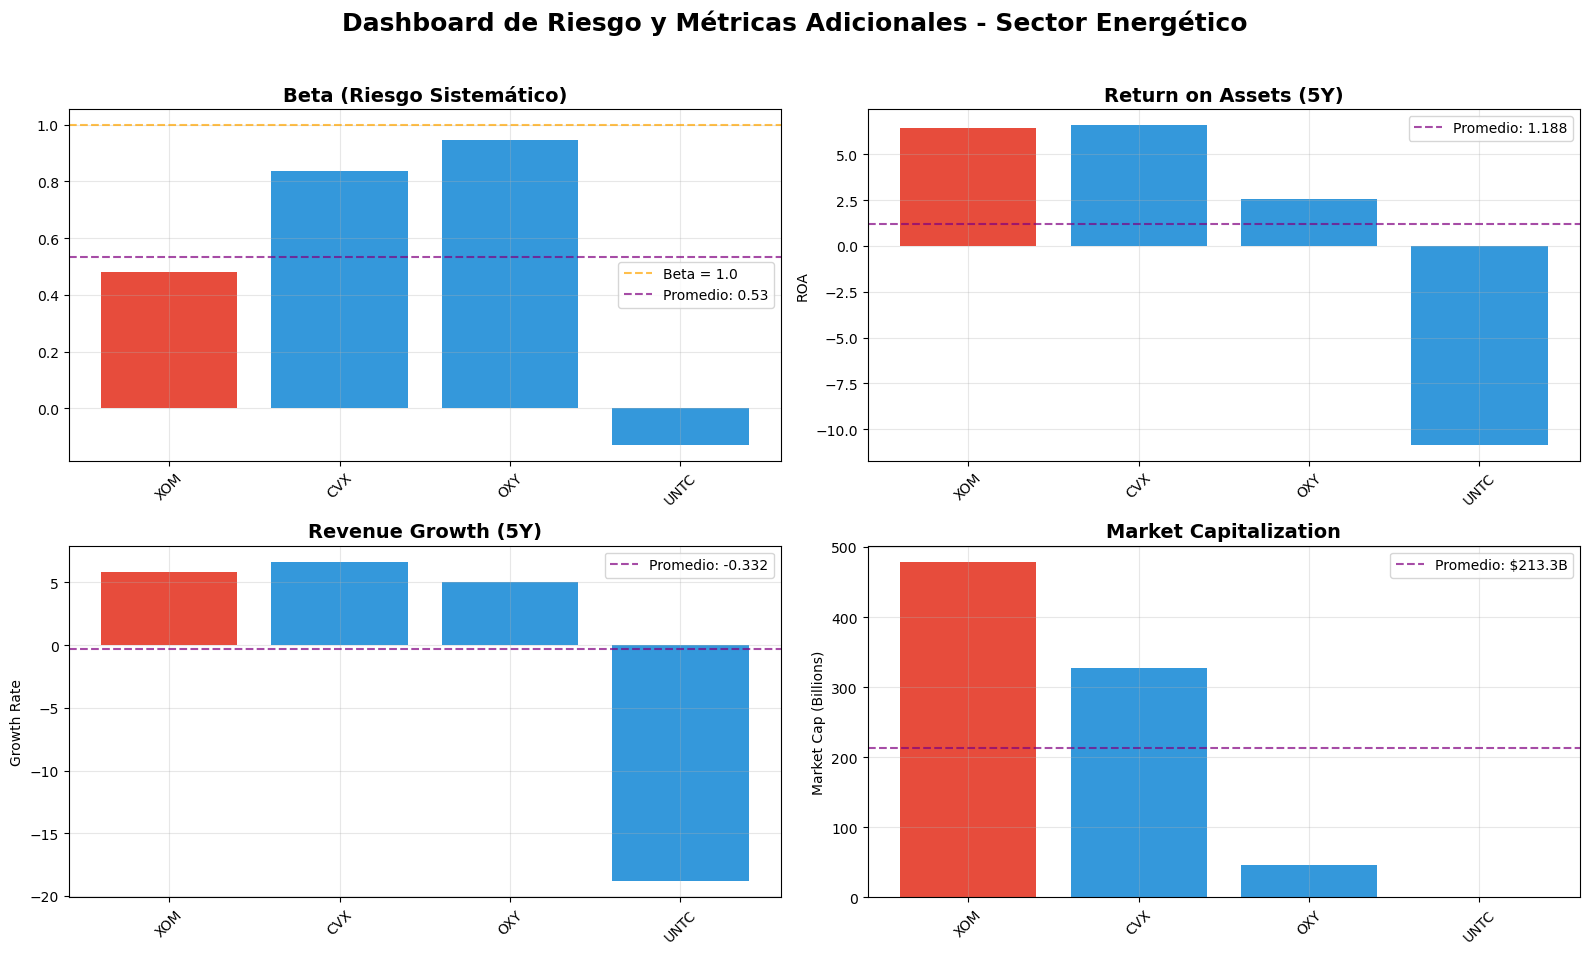


RANKING COMPARATIVO - SECTOR ENERGÉTICO
Empresa Semilla: XOM
Symbol   Company                   P/E TTM        P/B            P/S TTM        ROE TTM (%)    Net Margin TTM (%)
--------------------------------------------------------------------------------------------------------------
XOM      Exxon Mobil Corp          (*)15.44          1.82          1.45          11.730          9.420          
CVX      Chevron Corp             23.91          2.24          1.75          9.080          7.310          
OXY      Occidental Petroleum Co  19.47          1.31          1.72          6.890          8.840          
UNTC     Unit Corp                6.42          1.17          1.28          6.230          19.880          

(*) Empresa semilla


In [91]:
# Ejecutar análisis
df_energy = analyze_energy_sector()